In [39]:
import pandas as pd
import numpy as np
import mlfinlab as ml
import matplotlib.pyplot as plt

DIR = 'data/15min/'

In [15]:
df = pd.read_parquet(DIR + 'tick.parq')
df

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2017-01-01 16:51:46.482,3207,968.50,1009.87,960.90,1001.92,10898.346451,6149.839248,3207,1.068215e+07
2017-01-02 01:51:43.897,6414,1001.99,1007.00,994.27,1000.83,10756.455810,4927.483138,3207,1.076450e+07
2017-01-02 12:09:58.357,9621,1000.96,1033.00,999.67,1031.00,12930.475671,7019.737063,3207,1.312191e+07
2017-01-02 17:19:48.156,12828,1031.00,1035.00,997.35,1022.88,10566.715026,4202.251535,3207,1.078014e+07
2017-01-03 00:30:28.830,16035,1022.86,1032.01,1003.73,1032.00,13155.775532,6255.787105,3207,1.340723e+07
...,...,...,...,...,...,...,...,...,...
2019-04-30 22:45:29.149,41540271,5273.00,5282.00,5273.00,5278.00,2403.083245,1621.865609,3207,1.268540e+07
2019-04-30 22:57:18.360,41543478,5278.00,5278.00,5264.50,5273.00,2818.339908,1062.074335,3207,1.485578e+07
2019-04-30 23:09:54.280,41546685,5273.00,5275.50,5264.50,5265.00,2550.260744,810.889700,3207,1.344145e+07


### 1. Compute daily volatility

We want to set profit taking and stop-loss limits that are a function of the risks involved in a bet. Otherwise, sometimes we'll be aiming too high, and sometimes too low, considering the prevailing volatility.

The follwing computes the daily volatility at intraday estimation points, applying a span of 50 days to an exponentially weighted moving standard deviation.

In [22]:
volatility = ml.util.get_daily_vol(close=df.close, lookback=50)
volatility

date_time
2017-01-02 17:19:48.156         NaN
2017-01-03 00:30:28.830    0.006436
2017-01-03 14:29:06.989    0.022780
2017-01-04 01:50:24.696    0.018431
2017-01-04 11:15:39.794    0.023539
                             ...   
2019-04-30 22:45:29.149    0.007708
2019-04-30 22:57:18.360    0.007834
2019-04-30 23:09:54.280    0.007860
2019-04-30 23:21:13.060    0.007709
2019-04-30 23:41:49.083    0.007578
Name: close, Length: 81416, dtype: float64

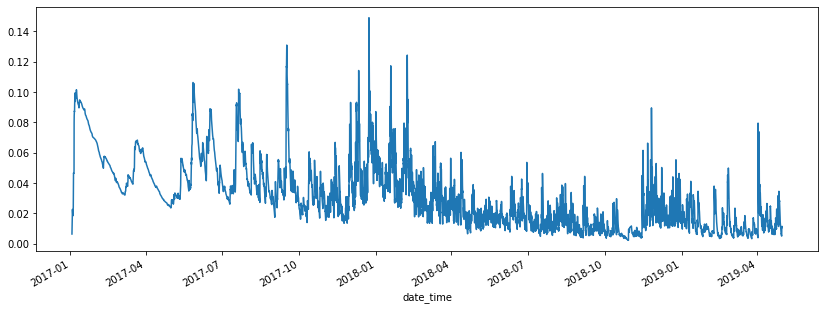

In [17]:
volatility.plot(figsize=(14, 5))

### 2. Apply the symmetric CUSUM filter

CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a mesured quantity away from a target value. The filter is set up to identify a sequence of upside or downside divergences from any reset level zero. We sample a bar t if and only if S_t >= threshold, at which point S_t is reset to 0.

One practical aspect that makes CUSUM filters appealing is that multiple events are not triggered by the raw time series hovering around a threshold level, which is a flaw suffered by popular market signals such as Bollinger Bands. It will require a full run of length threshold for raw time series to trigger an event.

Once we have obtained this subset of event-driven bars, we will let the ML algorithm determine whether the occurence of such events constitutes actionable intelligence.

In [25]:
cusum_events = ml.filters.cusum_filter(df.close, threshold=volatility)
cusum_events

DatetimeIndex(['2017-01-03 00:30:28.830000', '2017-01-04 01:50:24.696000',
               '2017-01-04 11:15:39.794000', '2017-01-04 18:03:28.122000',
               '2017-01-05 09:26:07.772000', '2017-01-05 13:12:10.613000',
               '2017-01-06 11:52:48.313000', '2017-01-08 08:11:37.067000',
               '2017-01-11 09:49:50.128000', '2017-01-11 12:19:43.111000',
               ...
               '2019-04-30 04:37:10.954000', '2019-04-30 07:33:41.637000',
               '2019-04-30 10:06:18.340000', '2019-04-30 10:16:04.191000',
               '2019-04-30 11:59:47.194000', '2019-04-30 13:21:45.560000',
               '2019-04-30 13:22:28.926000', '2019-04-30 13:26:38.368000',
               '2019-04-30 17:57:02.817000', '2019-04-30 22:12:18.581000'],
              dtype='datetime64[ns]', length=5867, freq=None)

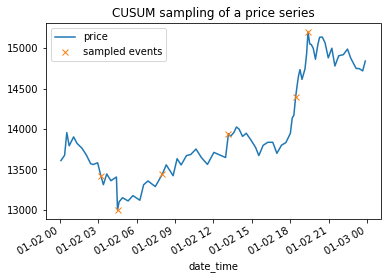

In [43]:
plt.title('CUSUM sampling of a price series')
df.loc['2018-01-02', 'close'].plot(label='price')
df.loc[cusum_events, 'close'].loc['2018-01-02'].plot(ls='', 
                                                     marker='x', 
                                                     label='sampled events')
plt.legend()

### Note: Triple Barrier Method

The Tripple Barrier Method is a method that labels an observation according to the first barrier thouched out of three barriers. The two horizontal barriers are defined by profit-taking and stop-loss limits, which are a dyanmic function of estimated volatility. The third barrier is defined in terms of number of bars elapsed since the position was taken (an expiration limit).

An observation is label based on which barrier is touched first:

     1 - upper barrier
    -1 - lower barrier
     0 - vertical barrier (the sign of the return can be used in place of zero)

<center>
    <img src="https://mlfinlab.readthedocs.io/en/latest/_images/triple_barrier.png" alt="tripple barrier" title="Tripple Barrier Method" />
</center>

### 3. Add the vertical barriers

For each event in cusum_events it finds the timestamp of the next price bar at or immediately after a number of days. This vertical barrier can be used later in the tripple barrier method.

In [45]:
vertical_barriers = ml.labeling.add_vertical_barrier(cusum_events, 
                                                     df.close, 
                                                     num_days=1)
vertical_barriers

2017-01-03 00:30:28.830   2017-01-04 01:50:24.696
2017-01-04 01:50:24.696   2017-01-05 02:23:41.346
2017-01-04 11:15:39.794   2017-01-05 12:01:24.882
2017-01-04 18:03:28.122   2017-01-05 22:22:49.861
2017-01-05 09:26:07.772   2017-01-06 11:52:48.313
                                    ...          
2019-04-29 18:15:37.199   2019-04-30 18:20:27.175
2019-04-29 20:52:32.392   2019-04-30 21:10:28.240
2019-04-29 22:25:12.169   2019-04-30 22:40:13.142
2019-04-29 22:38:50.358   2019-04-30 22:40:13.142
2019-04-29 23:11:17.251   2019-04-30 23:21:13.060
Name: date_time, Length: 5855, dtype: datetime64[ns]

### 4. Get the first barrier touch

In [47]:
pt_sl = [1, 1] # profit taking/ stop loss multiples of target level
min_ret = 0.01

triple_barrier_events = ml.labeling.get_events(close=df.close,
                                              t_events=cusum_events,
                                              pt_sl=pt_sl,
                                              target=volatility,
                                              min_ret=min_ret,
                                              num_threads=1,
                                              vertical_barrier_times=vertical_barriers,
                                              side_prediction=None)
triple_barrier_events

,t1,trgt,pt,sl
2017-01-04 01:50:24.696,2017-01-04 11:15:39.794,0.018431,1,1
2017-01-04 11:15:39.794,2017-01-04 18:03:28.122,0.023539,1,1
2017-01-04 18:03:28.122,2017-01-05 09:26:07.772,0.047019,1,1
2017-01-05 09:26:07.772,2017-01-05 13:12:10.613,0.047089,1,1
2017-01-05 13:12:10.613,2017-01-06 02:04:20.311,0.073349,1,1
...,...,...,...,...
2019-04-26 02:26:12.230,2019-04-26 16:25:35.416,0.016326,1,1
2019-04-26 02:44:47.216,2019-04-26 06:31:06.774,0.015294,1,1
2019-04-26 05:01:44.654,2019-04-26 16:01:22.531,0.010933,1,1
2019-04-27 19:19:55.998,2019-04-28 19:24:57.341,0.017624,1,1


In [48]:
labels = ml.labeling.get_bins(triple_barrier_events, df.close)
labels

,ret,trgt,bin
2017-01-04 01:50:24.696,0.036142,0.018431,1
2017-01-04 11:15:39.794,0.061933,0.023539,1
2017-01-04 18:03:28.122,-0.089188,0.047019,-1
2017-01-05 09:26:07.772,-0.107505,0.047089,-1
2017-01-05 13:12:10.613,0.081253,0.073349,1
...,...,...,...
2019-04-26 02:26:12.230,-0.018018,0.016326,-1
2019-04-26 02:44:47.216,-0.016789,0.015294,-1
2019-04-26 05:01:44.654,-0.012170,0.010933,-1
2019-04-27 19:19:55.998,-0.013603,0.017624,0


In [153]:
def plot_barriers(day_idx, ax):
    start_event = triple_barrier_events.index[day_idx]
    vertical_bar = vertical_barriers.loc[start_event]
    pt_level = df.close[start_event] * (1 + labels.loc[start_event, 'trgt'])
    sl_level = df.close[start_event] * (1 - labels.loc[start_event, 'trgt'])
    start_price = df.close[start_event]

    ax.plot(df.close[start_event-pd.Timedelta(hours=1) : vertical_bar+pd.Timedelta(hours=1)], color='k')

    # cusum event
    ax.plot([start_event, start_event], [sl_level, pt_level], color='r')

    # cusum price level
    ax.plot([start_event, vertical_bar], [start_price, start_price], color='r')

    # vertical barrier
    ax.plot([vertical_bar, vertical_bar], [sl_level, pt_level], color='r', ls='--')

    # take-profit level
    ax.plot([start_event, vertical_bar], [pt_level, pt_level], color='r', ls='--')

    # stop-loss level
    ax.plot([start_event, vertical_bar], [sl_level, sl_level], color='r', ls='--')

    # first close price after barrier touch
    ax.plot(df.close[[triple_barrier_events.loc[start_event, 't1']]], marker='D', ms=10, color='r')

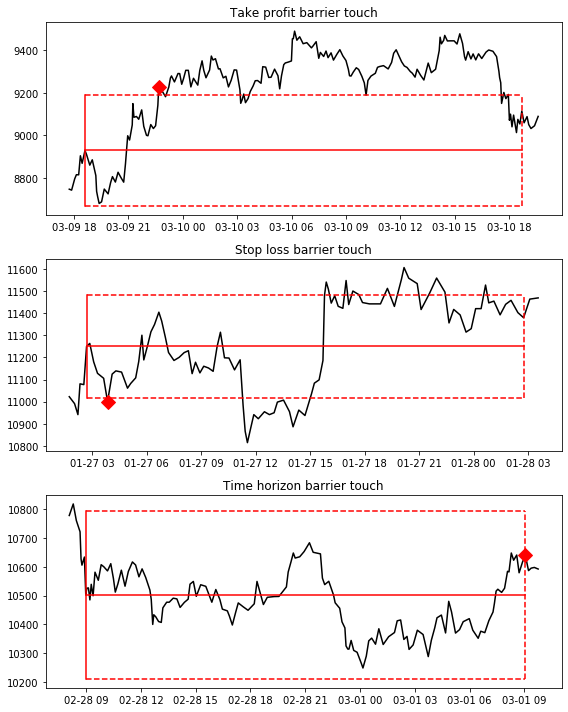

In [170]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

axes[0].set_title('Take profit barrier touch')
plot_barriers(1700, axes[0])

axes[1].set_title('Stop loss barrier touch')
plot_barriers(1300, axes[1])

axes[2].set_title('Time horizon barrier touch')
plot_barriers(1600, axes[2])

plt.tight_layout()